In [1]:
import cv2
import numpy as np
from scipy import ndimage as ndi

import matplotlib
from matplotlib import pyplot as plt
from scipy import signal
from scipy.signal import convolve2d

import pywt
from scipy import stats
from tabulate import tabulate

from skimage.feature import graycomatrix

import sys
np.set_printoptions(threshold=sys.maxsize)
matplotlib.rc('image', cmap='gray')

# FUNCTION DEFINITIONS

In [2]:
def ee(LH: np.array, HL: np.array, p = 2.0):
    return (np.absolute(LH)**p + np.absolute(HL)**p)**(1.0/p)

# IMPORTING IMAGE

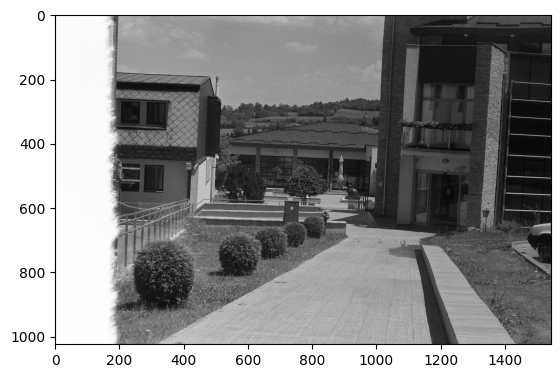

In [3]:
img = cv2.imread("res/img/054.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Bluring helps with very noisy images:
#img = cv2.medianBlur(img, 3)

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

#np.savetxt("res/test.raw", img, fmt="%i")

## Edge detection using proposed algorithm

This is the filtering step to get energy map:

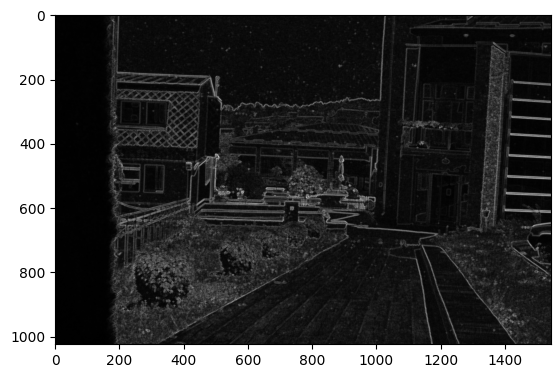

In [4]:
h = 0.125 * np.array([-1, 2, 6, 2, -1],     dtype=np.float32)
g1 = 0.5 *  np.array([1, 0, -1],            dtype=np.float32)
g2 = 0.5 *  np.array([1, 0, 0, 0, -1],      dtype=np.float32)
g3 = 0.5 *  np.array([1, 0, 0, 0, 0, 0 -1], dtype=np.float32)

gs = [g1, g2, g3]
filters = []


for g in gs:
    convolved_filter = np.convolve(h, g)
    padding = convolved_filter.shape[0]//2
    filters.append(
        np.pad(np.atleast_2d(convolved_filter),
               ((padding, padding), (0,0)))
    )



ees = []
imgf = np.array(img, dtype=np.float32)
for f in filters:
    imgh = convolve2d(imgf, f, mode='same', boundary='symm')
    imgv = convolve2d(img, f.T, mode='same', boundary='symm')
    ees.append(ee(imgh, imgv, p=2))

energy_map = np.zeros(ees[0].shape)
for e in ees:
    energy_map = np.maximum(energy_map, e)

energy_map = energy_map / np.max(energy_map)

plt.figure()
plt.imshow(energy_map, cmap="gray")
plt.show()

Tresholding the map with all-at-once algorithm:

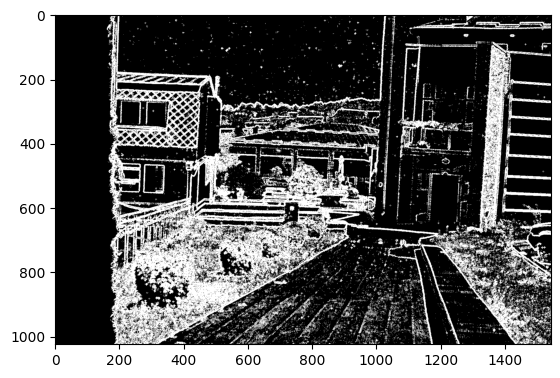

In [5]:
#energy_map1 = energy_map.copy()
#for val in range(levels):
#    energy_map1[img_thresh==val] = (energy_map1[img_thresh==val] > thresholds[val])

energy_map1 = energy_map.copy()
energy_map1[energy_map1 < 2*np.median(energy_map)] = 0
energy_map1[energy_map1 > 0] = 1

#energy_map1[energy_map1 < np.mean(energy_map1)*1.9] = 0

plt.figure()
plt.imshow(energy_map1, cmap="gray")
plt.show()

Cleanup of isolated pixels:

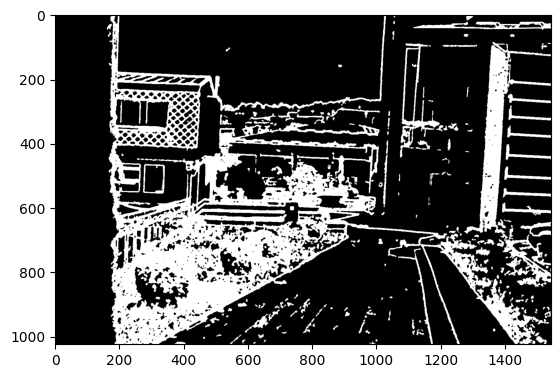

In [6]:
cleaned1 = cv2.medianBlur(
    cv2.normalize(energy_map1, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U), 5)

#cleaned1 = np.array(energy_map1, dtype=np.uint8)
nb_blobs, im_with_separated_blobs, constats, _ = cv2.connectedComponentsWithStats(cleaned1)
sizes = constats[:, -1]
sizes = sizes[1:]
nb_blobs -= 1

min_size = 30

cleaned = np.zeros_like(im_with_separated_blobs)

for blob in range(nb_blobs):
    if sizes[blob] >= min_size:
        cleaned[im_with_separated_blobs == blob + 1] = 255

plt.figure()
plt.imshow(cleaned, cmap="gray")
plt.show()

Using Canny just for fun:

### Dilating areas:

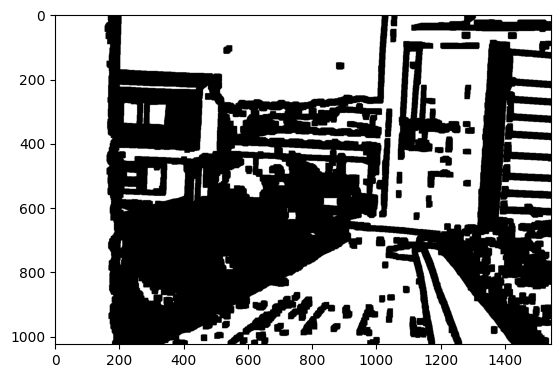

In [7]:
dilation_kernel = np.ones((15,15), dtype=np.uint8)
final_mask = cv2.dilate(np.array(cleaned, dtype=np.uint8), dilation_kernel, iterations=1)
final_mask = cv2.bitwise_not(final_mask)
final_mask[final_mask < 255] = 0
final_mask[final_mask != 0] = 1

plt.figure()
plt.imshow(final_mask, cmap="gray")
plt.show()

790528.0 15810.56
171873
182537
163564
120571
25932
Number of detected areas: 5


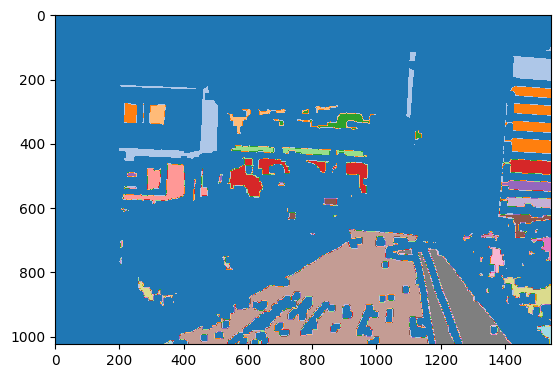

In [8]:
connectivity_map = np.ones((3,3), dtype=np.uint8)
areas, num_features = ndi.label(final_mask, connectivity_map)
# TODO: Exclude edge areas

vals, counts = np.unique(areas, return_counts=True)
# This excludes BG:
vals = vals[1:]
counts = counts[1:]

threshold_min = img.size*0.01
threshold_max = img.size*0.5
print(threshold_max, threshold_min)
grain_area_indices = []
for val, cnt in zip(vals, counts):
    if cnt >= threshold_min and cnt <= threshold_max:
        print(cnt)
        grain_area_indices.append(val)

print("Number of detected areas: {0}".format(len(grain_area_indices)))

plt.figure()
plt.imshow(areas, cmap="tab20")
plt.show()

### Grain analysis:

In [17]:
def statistic_analysis(data):
    noise_min = np.min(data)
    noise_max = np.max(data)
    noise_mean = np.mean(data)
    noise_median = np.median(data)
    noise_std  = np.std(data)
    noise_kurtosis = stats.kurtosis(data)
    noise_skewness = stats.skew(data)

    return [noise_min, noise_max, noise_mean, noise_median, noise_std, noise_kurtosis, noise_skewness]


def find_maxima(data):
    data_mean = np.mean(data)
    
    wavelet = "sym7"
    coeffs = pywt.wavedec(data, wavelet, level=3)
    coeffs[1:] = [pywt.threshold(c, value=0.5, mode='soft') for c in coeffs[1:]]
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    maxima = signal.argrelmax(smoothed_data, order=15, )
    print(maxima)
    maxima = maxima[0]
    maxima = [m for m in maxima if  data[m] > data_mean/8]

    return maxima, smoothed_data


#TODO
def coocm(image, depth = 256, dilation_kernel = np.ones((3,3), dtype=np.uint8)):
    coocmat = np.zeros((256, 256), dtype = np.float32)
    
    for level in range(depth):
        print(level)
        plate = np.zeros(image.shape, dtype = np.uint8)
        plate[image==level] = 1
        plate_dilated = cv2.dilate(plate, dilation_kernel, iterations=1)
        plate = plate_dilated - plate
        print(plate)

        vals, _, _, counts = np.unique(image[plate])
        for val, cnt in zip(vals, counts):
            coocmat[level, val] = cnt

    print(coocmat)
        

In [10]:
d = np.zeros((3,3))
d[1,2] = 1
x = [k for k in range(9)]

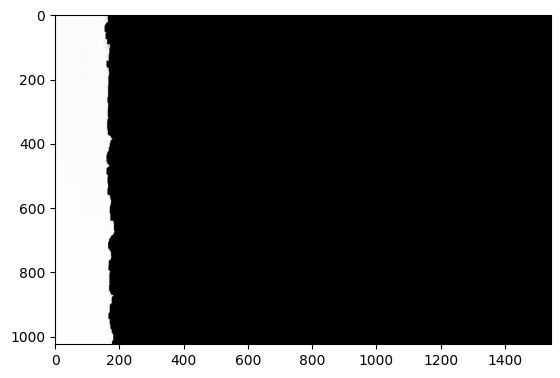

(array([], dtype=int64),)


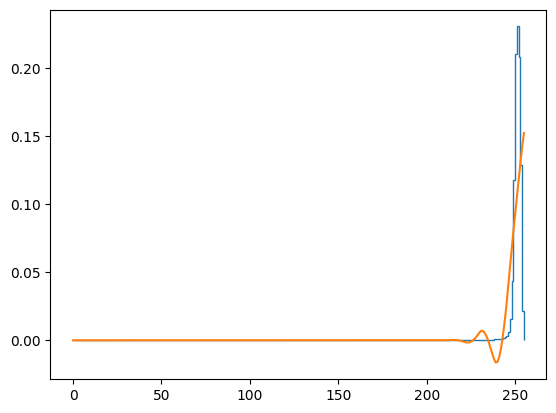

  min    max     mean    median      std    kurtosis    skewness
-----  -----  -------  --------  -------  ----------  ----------
  192    255  251.672       252  2.31536     59.5695    -5.16257


In [19]:
id = grain_area_indices[0]

first_area = img.copy()
first_area = np.array(img, dtype=np.float32)
first_area[areas!=id] = -1

only_noise = img.copy()
only_noise[areas!=id] = 0

plt.figure()
plt.imshow(only_noise, cmap='gray')
plt.show()


hist, edges = np.histogram(first_area[areas==id], bins=256, range=(0,255))
hist = hist/np.sum(hist)
#edges = edges-noise_mean

maxima, smoothed_hist = find_maxima(hist)
plt.figure()
plt.stairs(hist, edges)
plt.plot(smoothed_hist)
plt.show()

if  len(maxima)>0 and np.max(maxima) - np.min(maxima) > 40:
    ret, _ = cv2.threshold(np.array(first_area, dtype = np.uint8)[areas==id], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    lower = first_area[np.logical_and(areas==id, first_area < ret)]
    upper = first_area[np.logical_and(areas==id, first_area >= ret)]
    noise = [statistic_analysis(lower), statistic_analysis(upper)]

    bounding_rec_img = first_area.copy()
    bounding_rec_img[np.logical_or(areas!=id, first_area <= ret)] = 0
    plt.figure()
    plt.imshow(bounding_rec_img)
    plt.show()
    bounding_rec_img[bounding_rec_img > 0] = 1
    bounding_rec_img = bounding_rec_img.astype(np.uint8)

    to_show = first_area.copy()
    to_show[np.logical_or(areas!=id, first_area <= ret)] = 0
    x,y,w,h = cv2.boundingRect(bounding_rec_img)
    plt.figure()
    plt.imshow(to_show[y:y+h, x:x+w])
    plt.show()
    

else:
    noise = [statistic_analysis(first_area[areas==id])]



#coocm(first_area)

print(tabulate(noise, headers=["min", "max", "mean", "median", "std", "kurtosis", "skewness"]))

In [ ]:
a = "AB.jpg"
a[:-1]